In [1]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [2]:
from src.modules import conf, fit, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor, XGBRFRegressor
warnings.simplefilter("ignore")
from feature_engine.creation import MathFeatures

/home/zahradnik/PycharmProjects/master_thesis/src/modules/__init__.py
/home/zahradnik/PycharmProjects/master_thesis


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [5]:
data = fit.load_pcls(
        'zahradnik',
        'running',
        conf["Paths"]["pcl"],
    )

100%|██████████| 386/386 [00:02<00:00, 163.85it/s]


In [6]:
low_dist, high_dist = preprocess.segment_data(data)
len(low_dist),len(high_dist)

(144, 242)

In [7]:
test_df = preprocess.load_test_activity(path="tracks/hradec_half.gpx",
                                        race_day ='2023-10-21-11-30')
print(len(test_df))

4421


In [8]:
if max(test_df.distance) > 10000:
    train_df = fit.clean_data(pd.concat(high_dist))
else:
    train_df = fit.clean_data(pd.concat(low_dist))
len(train_df)

681291

In [9]:
len(train_df.columns),len(test_df.columns)

(134, 61)

In [10]:
len(train_df),len(test_df)

(681291, 4421)

In [11]:
len(train_df[test_df.columns].columns),len(test_df.columns)

(61, 61)

# Cadence

In [12]:
clf = XGBRegressor()

In [13]:
clf.fit(train_df[test_df.columns], train_df.cadence)
test_df['cadence'] = clf.predict(test_df)
test_df['cadence'].mean()

93.00084

In [14]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

# Heart Rate

In [15]:
clf.fit(train_df[test_df.columns], train_df.heart_rate)
test_df["heart_rate"] = clf.predict(test_df)
test_df["heart_rate"].mean()

181.45023

In [16]:
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)

In [17]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

In [18]:
clf.fit(train_df[test_df.columns], train_df.enhanced_speed)
test_df["enhanced_speed"] = clf.predict(test_df)

In [19]:
percent_delay = int(len(test_df) * 0.02)  ## 2% delay

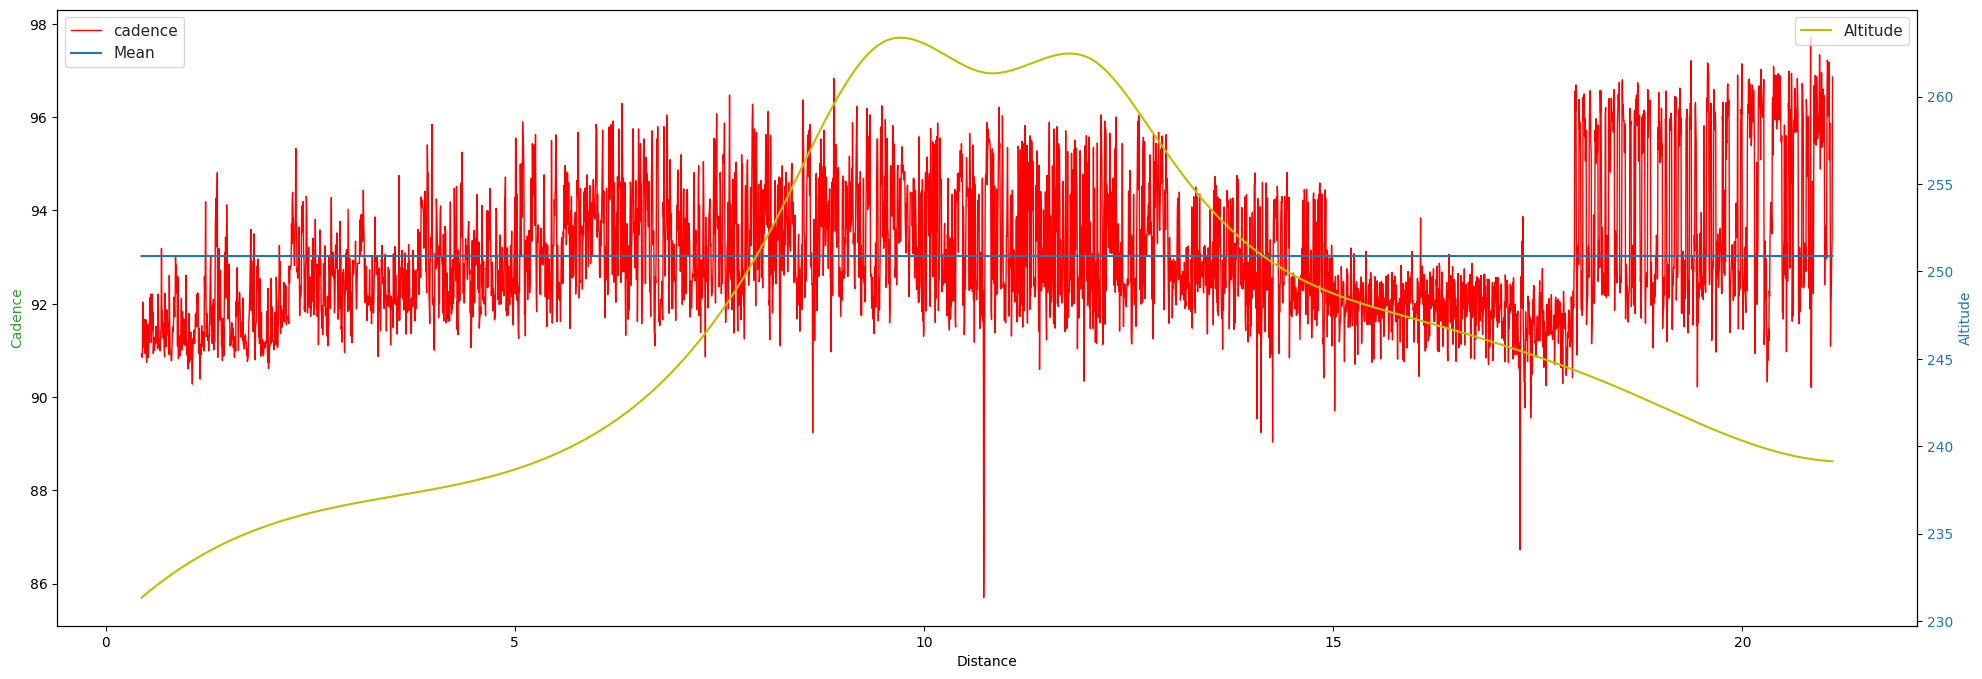

In [20]:
cad_plot = evl.plot(df=test_df[percent_delay:], pred=test_df['cadence'][percent_delay:],endog = "cadence", ylabel="Cadence", color="green")

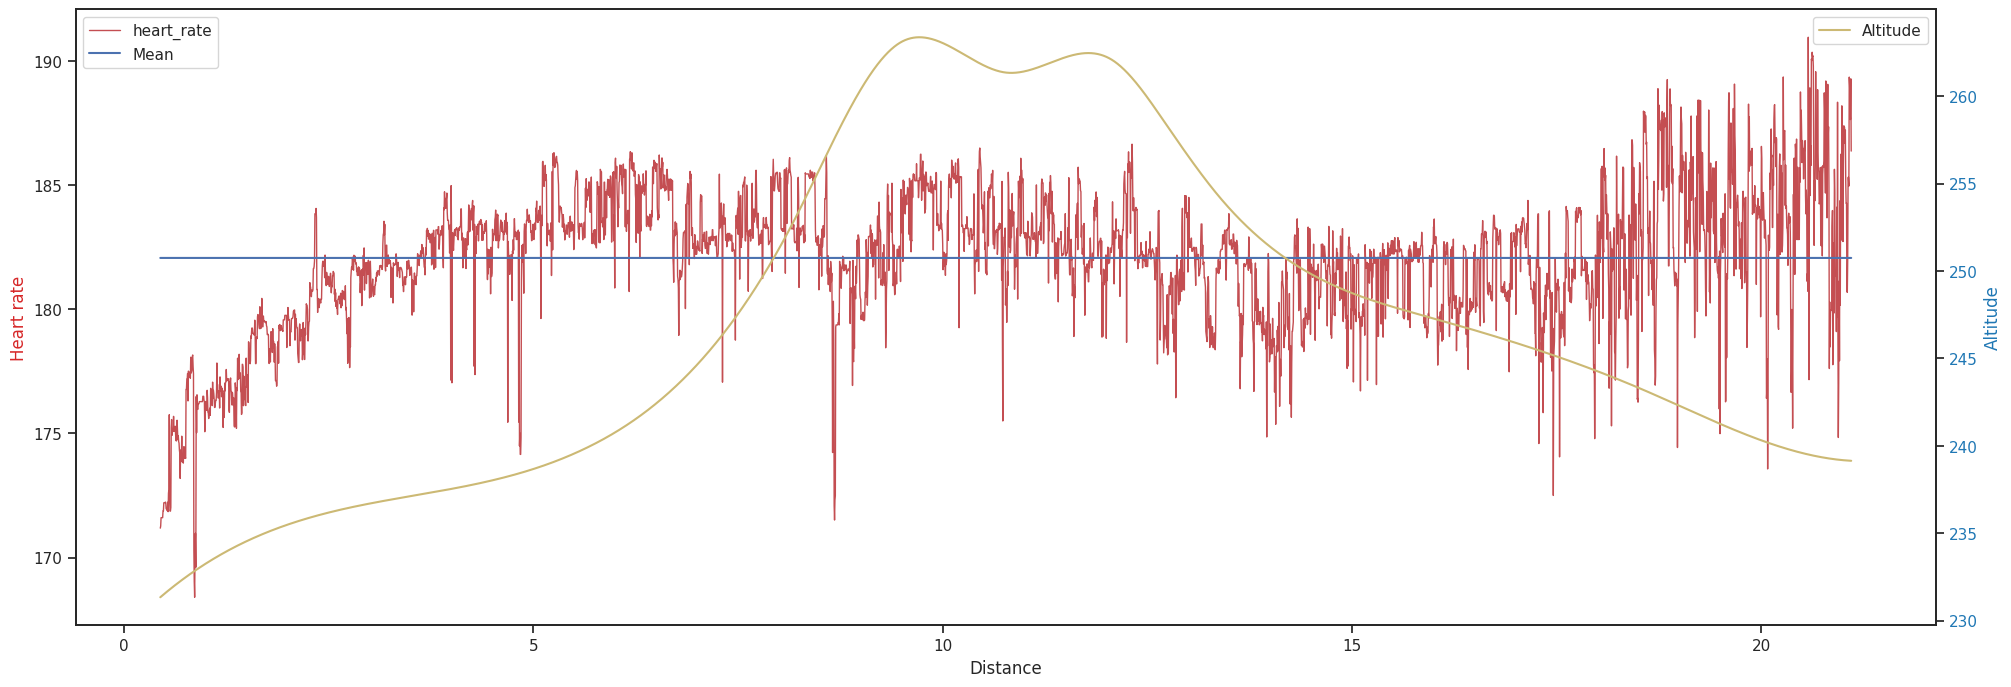

In [21]:
hr_plot = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],endog = "heart_rate",ylabel="Heart rate", color="red")

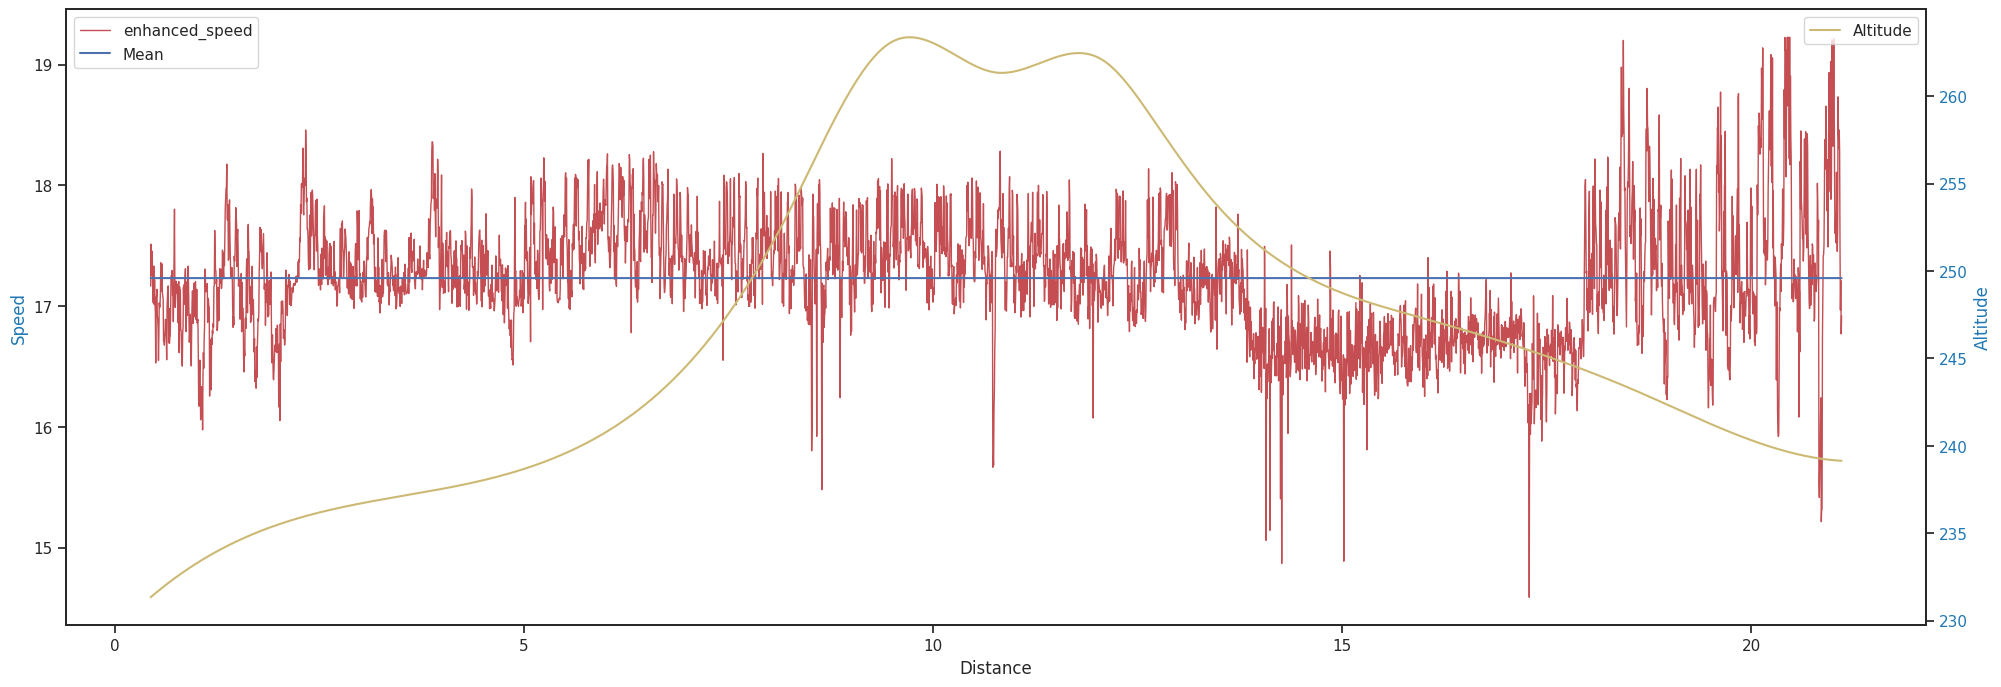

In [22]:
speed_plot = evl.plot(df=test_df[percent_delay:],pred=test_df["enhanced_speed"][percent_delay:],endog = "enhanced_speed",ylabel="Speed", color="blue")

In [23]:
np.mean(test_df.cadence), np.mean(test_df.heart_rate),np.mean(test_df["enhanced_speed"])

(93.00084, 181.45023, 17.216944)

In [24]:
y_pred_ridge = [x if x > 15 else np.mean(test_df["enhanced_speed"]) or x if x < 30 else np.mean(test_df["enhanced_speed"]) for x in test_df["enhanced_speed"]]

In [25]:
import math

# np.mean(speed_test), np.mean(y_pred_ridge), max(test_df.distance)
time = ((np.max(test_df.distance) / 1000) / np.mean(test_df["enhanced_speed"])) * 60
minutes = math.floor(time)
seconds = round((time - minutes) * 60)
if seconds == 60:
    seconds=0
    minutes+=1
final_time = f'Final time: {minutes}:{seconds}'
f'Final time: {minutes}:{seconds}'

'Final time: 73:32'

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

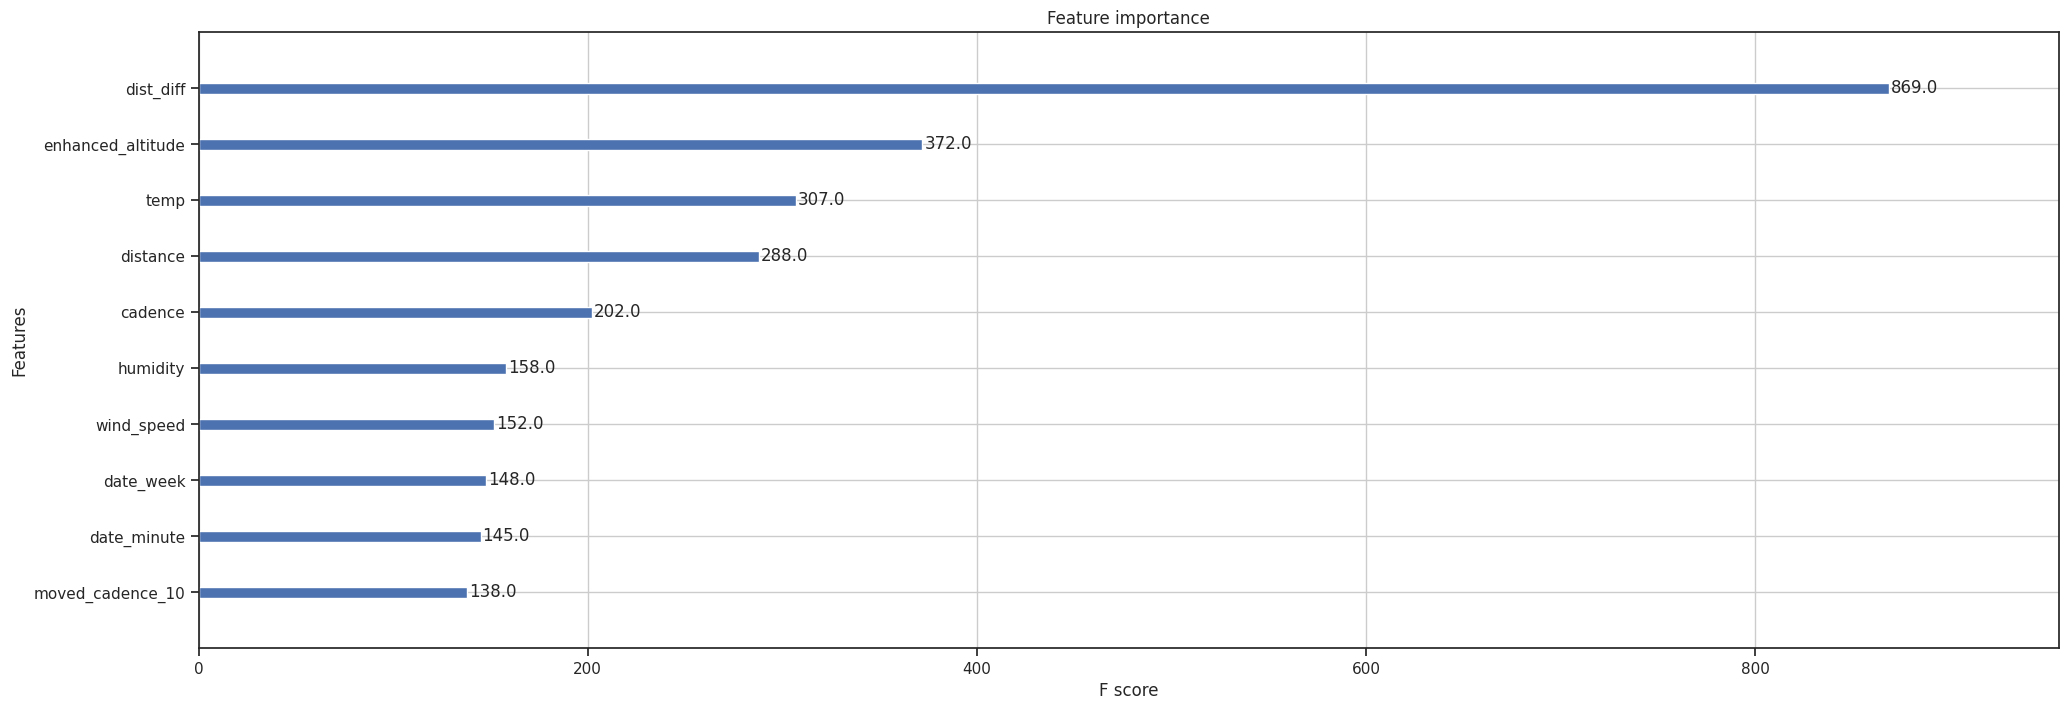

In [26]:
import xgboost as xgb
xgb.plot_importance(clf, max_num_features=10)

In [27]:
hradec = preprocess.load_test_activity(path="tracks/hradec_half.gpx",
                                        race_day ='2023-11-13-11-30')
fit.get_final_df(train_df=train_df,
                 test_df=hradec,
                 model=XGBRegressor())

'75:54'

In [28]:
silvestrak = preprocess.load_test_activity(path="tracks/silvestrak.gpx",
                                        race_day ='2023-11-10-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=silvestrak,
                 model=XGBRegressor())

'17:43'

In [29]:
boston = preprocess.load_test_activity(path="tracks/boston.gpx",
                                        race_day ='2023-11-12-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=boston,
                 model=XGBRegressor())

'146:20'

In [30]:
import os
os.listdir()

['pandas_profiling.html',
 'pcl_files',
 'res',
 'tracks',
 'logs',
 'raw_files',
 'map.html',
 'tools',
 'reports',
 'fit_files',
 'LICENSE',
 'venv',
 '.git',
 'requirements.txt',
 'config.yaml',
 'doc',
 '.idea',
 'README.md',
 'src',
 '.gitignore']

In [31]:
import folium
import gpxpy

# Read the GPX file and parse coordinates
gpx_file = "tracks/silvestrak.gpx"
gpx_data = open(gpx_file, "r").read()
gpx_parser = gpxpy.parse(gpx_data)

# Extract coordinates from GPX data
coordinates = []
for track in gpx_parser.tracks:
    for segment in track.segments:
        for point in segment.points:
            coordinates.append([point.latitude, point.longitude])

# Create a folium map centered around the first coordinate
map_center = [coordinates[0][0], coordinates[0][1]]
mymap = folium.Map(location=map_center, zoom_start=14)

# Add polyline to the map
folium.PolyLine(locations=coordinates, color="blue").add_to(mymap)

# Save the map as an HTML file
mymap.save("map.html")

# Read the saved HTML file
with open("map.html", "r") as file:
    html_content = file.read()

# Print or use the HTML content as needed
print(html_content)

<!DOCTYPE html>
<html>
<head>
    
    <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
    
        <script>
            L_NO_TOUCH = false;
            L_DISABLE_3D = false;
        </script>
    
    <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
    <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
    <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
    <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
    <link rel="stylesheet" href="

In [32]:
from src.modules import ui_output
ui_output.save_report(athlete_name=conf["Athlete"]["name"],
                      activity_name="bechovice.gpx"
                      .replace(".gpx","")
                      .capitalize(),
                      cad_plot=cad_plot,
                      hr_plot=hr_plot,
                      speed_plot=speed_plot,
                      final_time=final_time,
                      df=test_df)

HTML page with the plots next to each other has been created.


In [33]:
sum(test_df.slope_ascent)

274.20000000000067

In [34]:
ui_output.calc_stride_length(max(test_df.distance), test_df.cadence.mean())

226.89632742013475